# Interrupted time series with `pymc` models

In [1]:
import arviz as az
import pandas as pd
import pathlib

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Example

Load data

In [4]:
its_data_path = pathlib.Path.cwd().parents[1] / "causalpy" / "data" / "its.csv"
df = pd.read_csv(its_data_path, parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")

Run the analysis

In [5]:
from causalpy.pymc_experiments import InterruptedTimeSeries
from causalpy.pymc_models import LinearRegression

result = InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

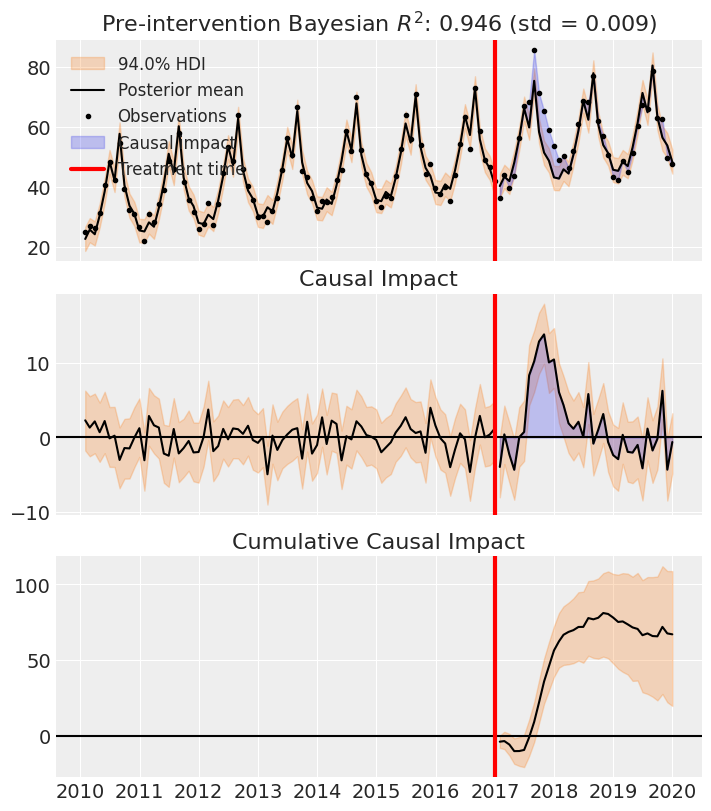

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

============================Interrupted Time Series=============================
Formula: y ~ 1 + t + C(month)
Model coefficients:
  Intercept                     22.72, 94% HDI [21.19, 24.27]
  C(month)[T.2]                 2.85, 94% HDI [0.87, 4.78]
  C(month)[T.3]                 1.18, 94% HDI [-0.84, 3.09]
  C(month)[T.4]                 7.15, 94% HDI [5.14, 9.15]
  C(month)[T.5]                 15.05, 94% HDI [13.00, 17.06]
  C(month)[T.6]                 24.78, 94% HDI [22.77, 26.77]
  C(month)[T.7]                 18.22, 94% HDI [16.24, 20.23]
  C(month)[T.8]                 33.49, 94% HDI [31.53, 35.47]
  C(month)[T.9]                 16.25, 94% HDI [14.18, 18.20]
  C(month)[T.10]                9.19, 94% HDI [7.21, 11.13]
  C(month)[T.11]                6.31, 94% HDI [4.26, 8.34]
  C(month)[T.12]                0.58, 94% HDI [-1.43, 2.61]
  t                             0.21, 94% HDI [0.19, 0.23]
  sigma                         1.97, 94% HDI [1.69, 2.30]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

<div class="alert alert-info">

Note

Better output for the summary statistics are in progress!

</div>

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.861,0.662,0.547,3.021,0.013,0.009,2554.0,3244.0,1.0


<div class="alert alert-warning">

Warning

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.

</div>

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,66.998,23.82,19.689,108.763,0.471,0.333,2554.0,3244.0,1.0
